In [61]:
import torch
import torch.nn as nn
from models import DualGridMLMMelHarm
from GridMLM_tokenizers import CSGridMLMTokenizer
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from torch.utils.data import DataLoader
from train_utils import apply_masking
from generate_utils import generate_files_with_greedy, generate_files_with_beam, load_model
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import save_attention_maps_with_split

In [62]:
# tokenizer = CSGridMLMTokenizer(fixed_length=256, intertwine_bar_info=True, trim_start=False)
tokenizer = CSGridMLMTokenizer(
        fixed_length=80,
        quantization='4th',
        intertwine_bar_info=True,
        trim_start=False,
        use_pc_roll=True,
        use_full_range_melody=False
    )
# val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_test'
val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_test'
# val_dir = '/media/maindisk/data/synthetic_CA_test'

In [63]:
num_steps = 20
# curriculum_type , total_stages = 'step' , num_steps
curriculum_type , total_stages = 'random', num_steps
# curriculum_type , total_stages = 'base2', num_steps
subfolder = 'DE/CA'
# subfolder = 'bar_qt/all12'
device_name = 'cuda:1'
model = load_model(
    d_model=512, 
    nhead=4, 
    num_layers_mel=4,
    num_layers_harm=4,
    curriculum_type=curriculum_type,
    subfolder=subfolder,
    device_name=device_name,
    tokenizer=tokenizer,
    conditioning_dim=8 + (curriculum_type == 'step'),
    total_stages=total_stages,
    melody_length=80,
    harmony_length=80,
)

In [64]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

29798755


In [65]:
import os
data_files = []
for dirpath, _, filenames in os.walk(val_dir):
    for file in filenames:
        if file.endswith('.xml') or file.endswith('.mxl') or file.endswith('.musicxml') \
            or file.endswith('.mid') or file.endswith('.midi'):
            full_path = os.path.join(dirpath, file)
            data_files.append(full_path)
print(len(data_files))

758


In [66]:
# val_idx = 1
# val_idx = 402
# val_idx = 401
# val_idx = 400
val_idx = 300 # besame
# TODO: check out 200, it has a problem rendering to file
# val_idx = 200

input_f = data_files[val_idx]
# input_f = 'example_inputs/test_midi_constraints.mid'

mxl_folder = 'examples_musicXML/' + subfolder + '/' + curriculum_type + '/' + '/'
midi_folder = 'examples_MIDI/' + subfolder + '/' + curriculum_type + '/' + '/'
os.makedirs(mxl_folder, exist_ok=True)
os.makedirs(midi_folder, exist_ok=True)

# gen_harm, real_harm, gen_score, real_score, avg_diffs = generate_files_with_greedy(
gen_harm, real_harm, gen_score, real_score, avg_diffs = generate_files_with_beam(
    model=model,
    tokenizer=tokenizer,
    input_f=input_f,
    mxl_folder=mxl_folder,
    midi_folder=midi_folder,
    name_suffix='bar_test',
    curriculum_type=curriculum_type,
    intertwine_bar_info=True,
    trim_start=False,
    normalize_tonality=False,
    use_constraints=False,
    condition='h_density_complexity',
    force_condition=None, # [1,0,0,0,1,0,0,0],
    temperature=1.0,
    beam_size=5,
    top_k=50,
    unmasking_order='end', # in ['random', 'start', 'end', 'certain', 'uncertain']
    focal_sharpness=0.01,
)

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/base.py:559: UserWarning: Setting an ID that could be mistaken for a memory location is discouraged: got 124247210775312
  warnings.warn(msg)


In [67]:
tokenizer.ids_to_tokens[269]

'A:min'

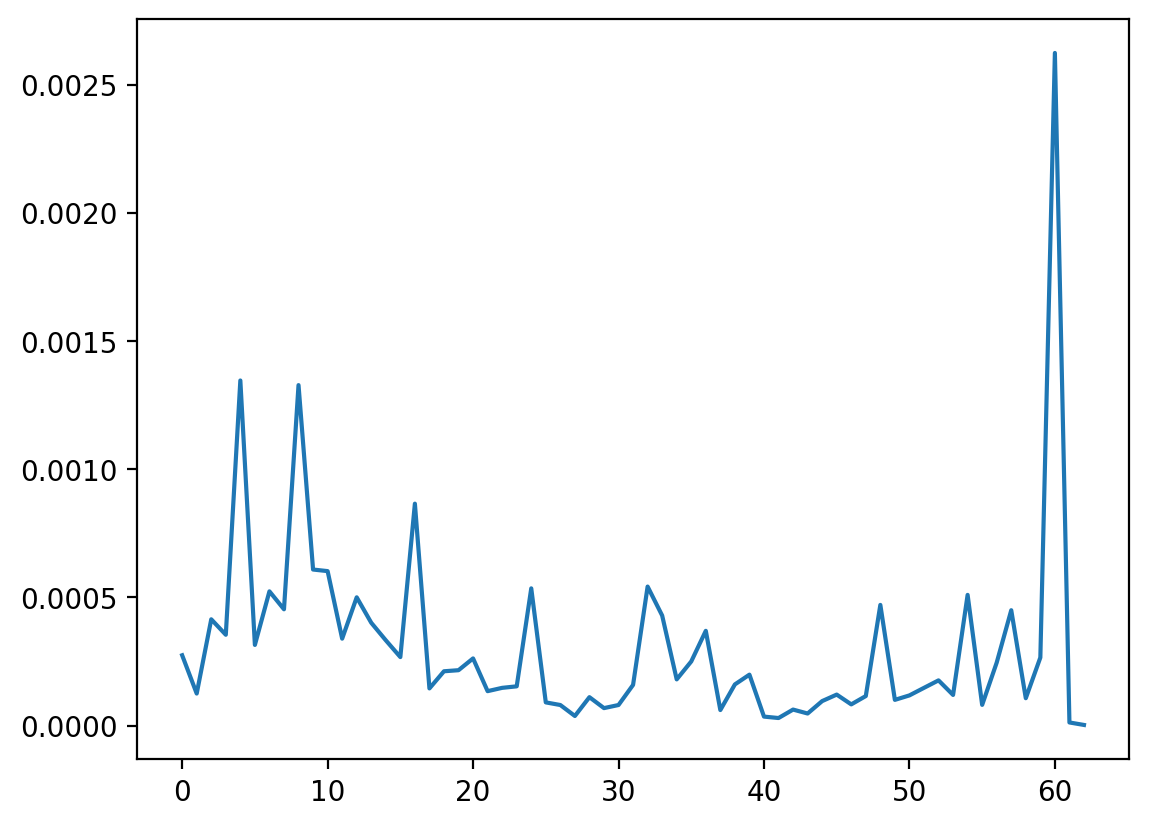

In [68]:
plt.plot(avg_diffs)

In [69]:
harm_string = '_'.join( gen_harm )
# print(gen_harm)
harm_bars = harm_string.split( '<bar>_' )
for h in harm_bars:
    print(h)


D:min9_D:min9_D:min9_D:min9_
D:min9_D:min9_D:min9_D:min9_
G:maj_G:maj_G:maj_G:maj_
D:min9_D:min9_D:min9_D:min9_
D:min9_D:min9_D:min9_D:min9_
D:min9_D:min9_D:min9_D:min9_
D:min9_D:min9_D:min9_D:min9_
D:min9_D:min9_D:min9_D:min9_
D:min9_D:min9_D:min9_D:min9_
D:min9_D:min9_D:min9_D:min9_
G:maj_G:maj_G:maj_G:maj_
G:maj_G:maj_G:maj_G:maj_
D:min9_D:min9_D:min9_D:min9_
D:min9_D:min9_D:min9_D:min9_
G:maj_G:maj_G:maj_G:maj_
G:maj_G:maj_<pad>_<pad>


In [70]:
harm_string = '_'.join( real_harm )
# print(gen_harm)
harm_bars = harm_string.split( '<bar>_' )
for h in harm_bars:
    print(h)


A:min_A:min_A:min_A:min_
A:min_A:min_A:min_A:min_
D:min_D:min_B:hdim7_B:hdim7_
D:min7_D:min7_B:hdim7_B:hdim7_
D:min_D:min_E:dim_E:dim_
D:min_D:min_E:7_E:7_
A:min_A:min_E:7_E:7_
A:min_A:min_A:min_A:min_
A:7_A:7_A:7_A:7_
A:7_A:7_A:7_A:7_
D:min_D:min_D:min_D:min_
D:min7_D:min7_A:sus2_D:min_
A:min_A:min_A:min_A:min_
D#:min_D#:min_E:7_E:7_
A:min_A:min_D:min_B:hdim7_
A:min_A:min_A:min_A:min


<Axes: >

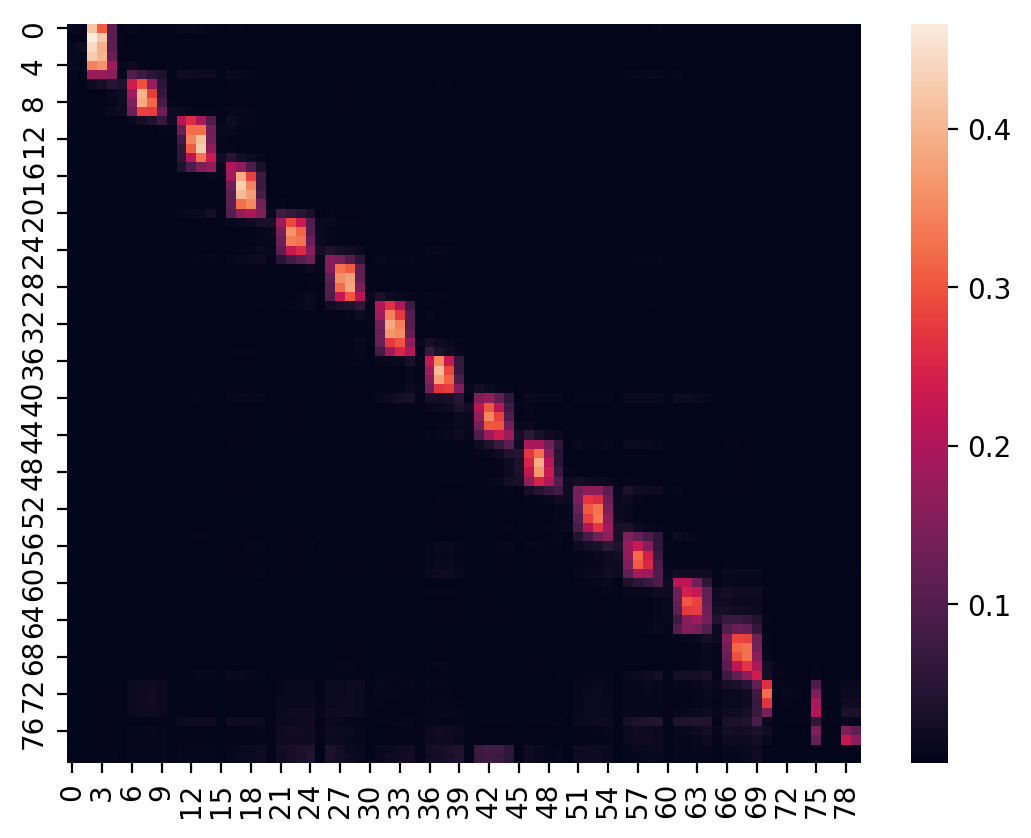

In [71]:
# After running a forward pass with attention outputs enabled
# attn_maps = model.harmony_encoder.layers[4].last_attn_weights  # example shape: [B, heads, L, L]
self_attns, cross_attns = model.get_attention_maps()

# Focus on one item in batch, one head
map = self_attns[0][0, 0].detach().cpu().numpy()
sns.heatmap(map)

In [72]:
melody_len = 80   # <-- replace with your real melody grid length
save_attention_maps_with_split(
    self_attns, 
    melody_len, 
    save_dir="figs/attn_maps/self/" + curriculum_type + str(num_steps), 
    prefix="self"
)
save_attention_maps_with_split(
    cross_attns, 
    melody_len, 
    save_dir="figs/attn_maps/cross/" + curriculum_type + str(num_steps), 
    prefix="cross"
)